# Deep Belief Network. A PyTorch Walkthrough

### `STILL UNDER MAINTENANCE AND IMPROVEMENT`

This notebook serves the purpose to display the results of a Deep Belief Network training. 

The training algorithm used is the _Greedy Layer-wise Algorithm_ : Each layer of the DBN is a Restricted Boltzmann Machine. Each of such layers is trained at once, and the transformed data of a layer are used as input data for the next layer. The performance of the trained device is assessed in two different ways. One can check the read-out accuracy of the top-end layer activities. This metric is expected to be close to `1`. If it is the case, then the data projections in the last layer are linearly separable, hence the activity associated to each input pattern can be uniquely associated with a _prototype_, in this case a digit shape.

On the other hand, one can check the quality of reconstructed samples. This reconstruction is made by propagating one input pattern $\boldsymbol{v} \rightarrow \boldsymbol{h_1} \rightarrow \boldsymbol{h_2} \rightarrow \dots \rightarrow \boldsymbol{h_n}$, and then back-propagating $\boldsymbol{h_n}$ up to the visible layer $\boldsymbol{v'}$ and see whether this reconstruction is satisfactorily faithful to the original sample. It is indeed the case, as shown below.

Other two sanity checks are implemented: Rather than merely reconstructing the original samples, the data instances are corrupted in two different ways

1. Since an image is a numerical matrix, the entries of which are numbers in $[0,1]$, the first corruption method is to set to $0$ some rows, e.g. from row 5 to row 10.
2. Alternatively, one can spoil the samples with Gaussian noise $\epsilon \sim \mathcal{N}(0, 0.1)$, and see how the device fares in recostructing the samples.

Either way, the performance could be considered satisfactory. See results below.

Additional sanity checks include the visualization of parameters and parameters updates histograms, cost profile and receptive fields. _L1_ regularization is implemented.

### Minimal references list

1. Hinton, Osindero and Teh, "A Fast Learning Algorithm for Deep Belief Nets", **2006**, _Neural Computation_ 18(7), pp. 1527-1554
2. Bengio, Lamblin, Popovici, Larochelle, "Greedy Layer-Wise Wraining of Deep Networks",  **2007**, In _Advances in neural information processing systems 19_
3. Hinton, "Training Products of Experts by Minimizing Contrastive Divergence", _Neural Computation_ 14(8), pp. 1771-1800
4. Hinton, "A Practical Guide to Training Restricted Boltzmann Machines", **2012**, In: Montavon G., Orr G.B., Müller KR. (eds) _Neural Networks: Tricks of the Trade. Lecture Notes in Computer Science_, vol 7700. Springer, Berlin, Heidelberg
5. Fischer and Igel "Training Restricted Boltzmann Machines: An Introduction", **2014**, _Pattern Recognition_ 47, pp. 25-39

# Code

Model instantiation, hyper-parameters tuning, dataset fetching, training.

In [5]:
import os
import sys
sys.path.append(os.getcwd() + r'\deepbeliefpack')

import pickle
import dataload as dld
from torchvision import transforms
import visual as vs
import rbm as rbms
import dbn as dbns

import torch
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available(), device)


"""
The main program is instructed whether to train a model again, which model, whether
to save the dataset and model as serialized objects.
Hyper-paramters as batch size, learning rate and network architecture must be 
defined by the user.
"""

data  = False
train = True
save  = False
load  = False
model = 'dbn'

if data:
    batch_size = 100
    transfs = [transforms.ToTensor()]
    loader = dld.LoadDataset(batch_size, transfs)
    Xtrain, Xtest, Ytrain, Ytest = loader.yield_tensor_data()
    vs.plot_images_grid(Xtrain[0,:,:],Ytrain[0,:,:], title = 'Raw data')
    
    dataset = {'train' : [Xtrain,Ytrain],
               'test'  : [Xtest, Ytest]}
    with open('dataset\dataset.pickle', 'wb') as handle: pickle.dump(dataset,handle)
else:
    with open('dataset\dataset.pickle','rb') as handle : dataset = pickle.load(handle)
    [Xtrain,Ytrain] = dataset['train']
    [Xtest, Ytest]  = dataset['test']
#end

True cuda:0


In [6]:
visible_dim = Xtrain[0,0].shape[0]
hidden_dims = [500, 500, 2000]

epochs        = 10
learning_rate = 0.01
weights_decay = 0.0005
momentum      = 0.5
mcmc_steps    = 1

hyperparameters = {'epochs'        : epochs,
                   'learning_rate' : learning_rate,
                   'weights_decay' : weights_decay,
                   'momentum'      : momentum,
                   'mcmc_steps'    : mcmc_steps}

Training RBM 1
____________________
Epoch 01 Training loss = 0.740820
Epoch 02 Training loss = 0.518501
Epoch 03 Training loss = 0.447944
Epoch 04 Training loss = 0.407715
Epoch 05 Training loss = 0.380020
Epoch 06 Training loss = 0.338363
Epoch 07 Training loss = 0.299478
Epoch 08 Training loss = 0.280056
Epoch 09 Training loss = 0.267838


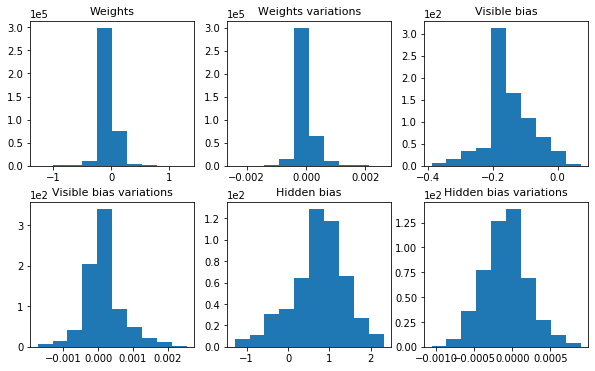

Epoch 10 Training loss = 0.259638


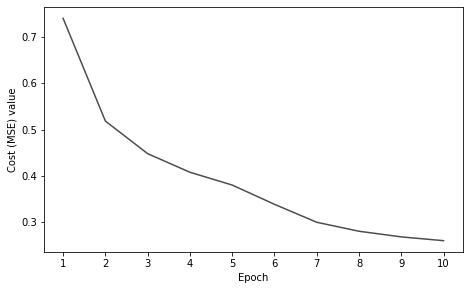

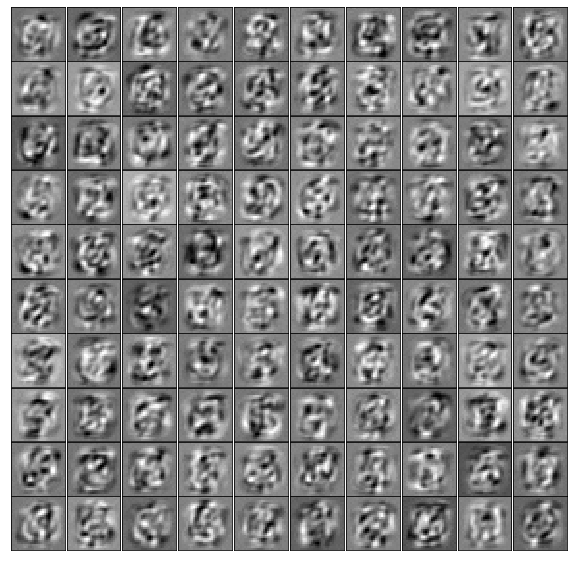

Training RBM 2
____________________
Epoch 01 Training loss = 1.304402
Epoch 02 Training loss = 0.977779
Epoch 03 Training loss = 0.872863
Epoch 04 Training loss = 0.816204
Epoch 05 Training loss = 0.780649
Epoch 06 Training loss = 0.732914
Epoch 07 Training loss = 0.694951
Epoch 08 Training loss = 0.679869
Epoch 09 Training loss = 0.671403


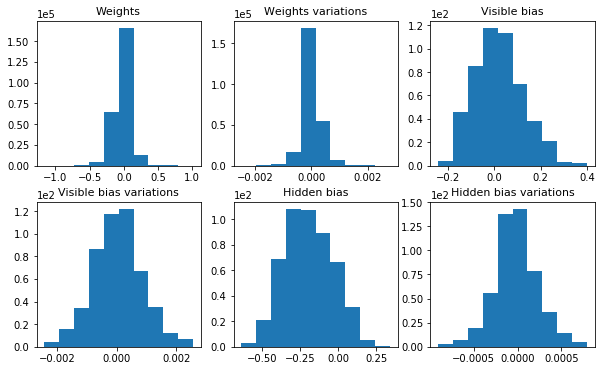

Epoch 10 Training loss = 0.666343


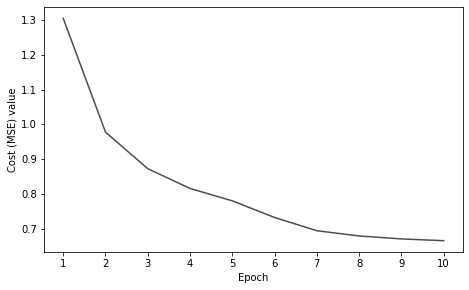

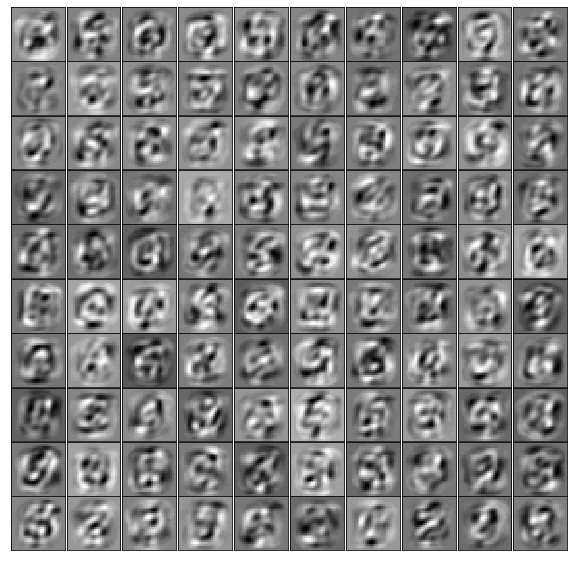

Training RBM 3
____________________
Epoch 01 Training loss = 0.883769
Epoch 02 Training loss = 0.610229
Epoch 03 Training loss = 0.539448
Epoch 04 Training loss = 0.506697
Epoch 05 Training loss = 0.487927
Epoch 06 Training loss = 0.467558
Epoch 07 Training loss = 0.450826
Epoch 08 Training loss = 0.443705
Epoch 09 Training loss = 0.439564


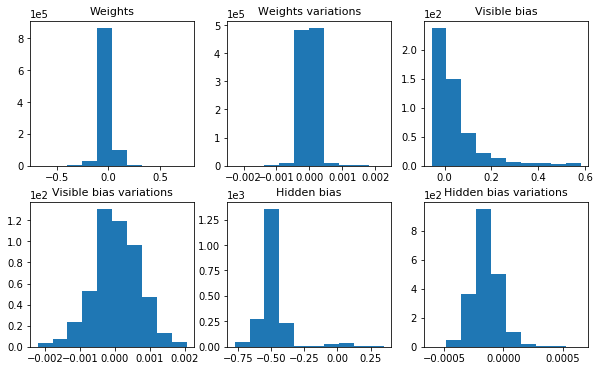

Epoch 10 Training loss = 0.437029


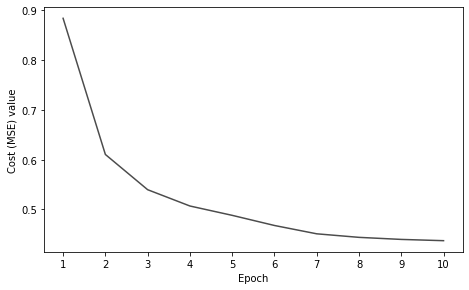

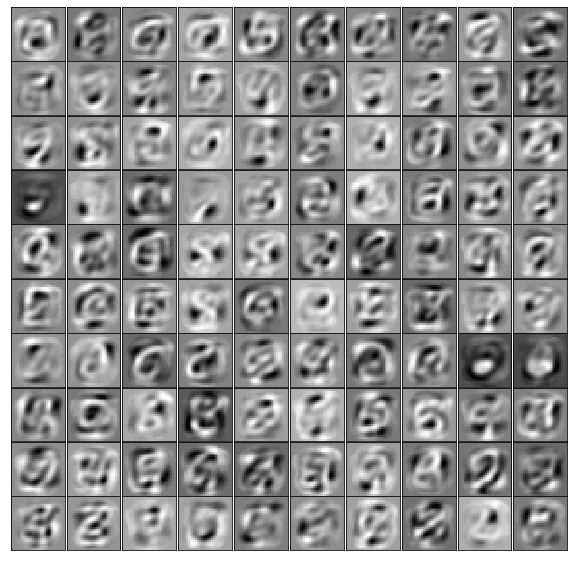

Read-out accuracy at the top-end layer: 0.955


In [7]:
if model == 'rbm':
    
    if train:
        rbm = rbms.RestrictedBoltzmannMachine(visible_dim, hidden_dims[0])
        rbm.contrastive_divergence_train([Xtrain,Ytrain], epochs,
                                          learning_rate, weights_decay, momentum,
                                          mcmc_steps)
        rbm.reconstruction([Xtest,Ytest])
        if save:
            with open('models\rbm.pickle','wb') as handle: pickle.dump(rbm, handle)
        #end
        
    elif load:
        net_model = {'model' : rbm, 'hyperparameters' : hyperparameters}
        with open('models\rbm.pickle','rb') as handle: rbm = pickle.load(handle)
    #end
    
elif model == 'dbn':
    
    if train:
        dbn = dbns.DeepBeliefNet(visible_dim, hidden_dims)
        [rbm.cuda() for rbm in dbn.rbm_layers]
        dbn.contrastive_divergence_train([Xtrain,Ytrain], epochs,
                                         learning_rate, weights_decay, momentum,
                                         mcmc_steps)
        if save:
            net_model = {'model' : dbn, 'hyperparameters' : hyperparameters}
            with open('models\dbn.pickle','wb') as handle: pickle.dump(net_model, handle)
        #end
    elif load:
        with open('models\dbn.pickle','rb') as handle: dbn = pickle.load(handle)
    #end
#end

# Sanity checks

### Linear classification read-out
A simple linear SVM has been used to assess the separability of the top-end layer. This model has been imported from the `sklearn.svm` module. 

Accuracy is `0.955` which is a poor value. To evaluate such metric, the first 3000 samples of the activity patterns obtained from the training set have been used. The following 200 samples are used as test set. SVMs have a complexity of $O(N^2)$, being $N$ the number of training samples. Hence the choice of few samples to train the SVM with is motivated by this fact.

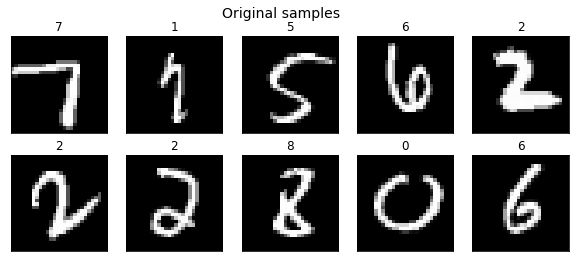

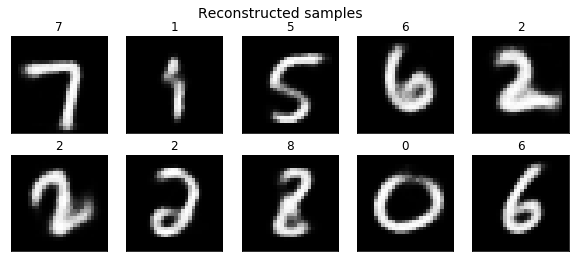

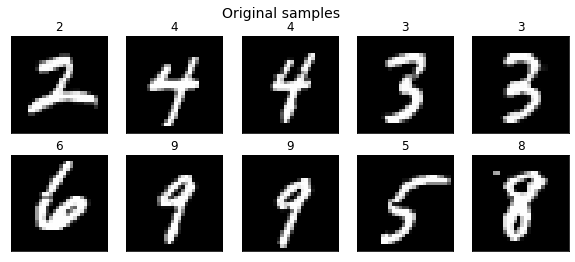

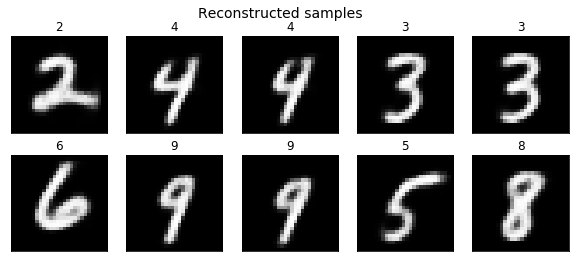

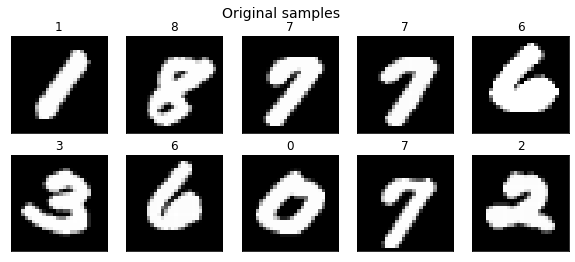

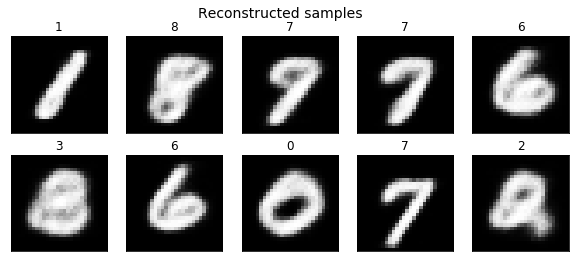

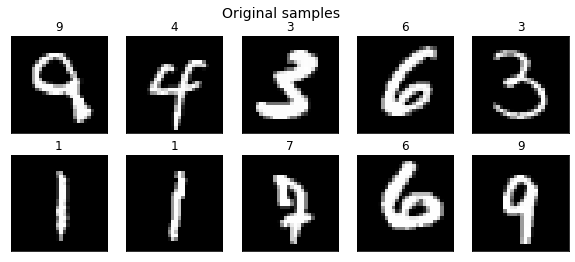

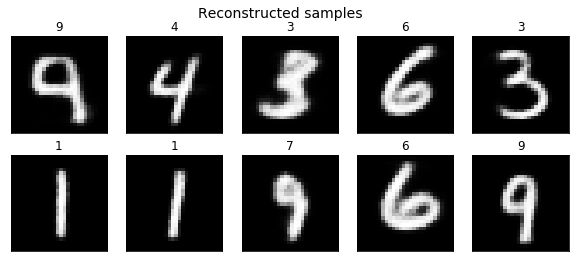

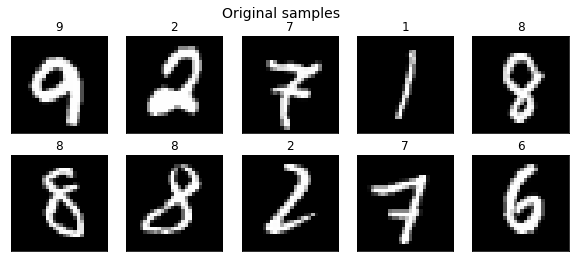

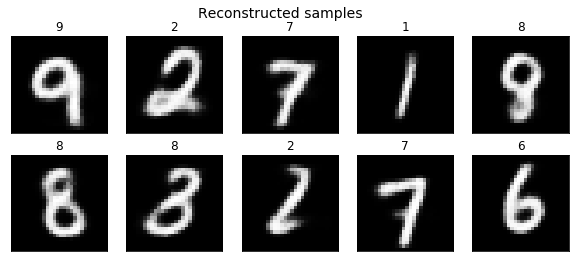

In [8]:
dbn.reconstruction([Xtest,Ytest], title = 'Original samples')

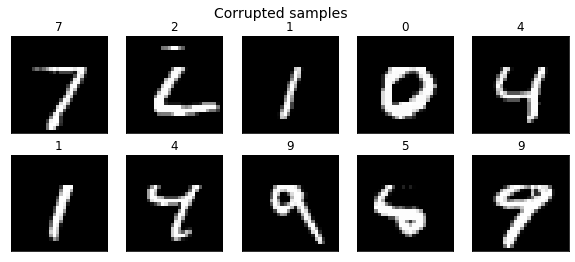

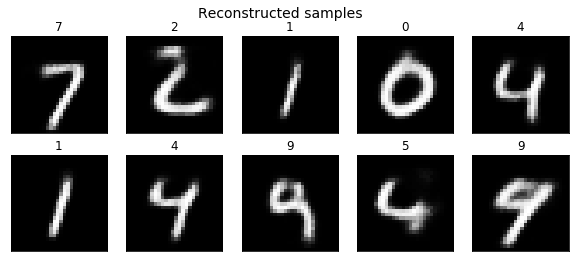

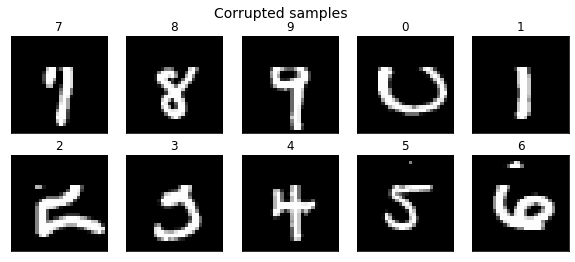

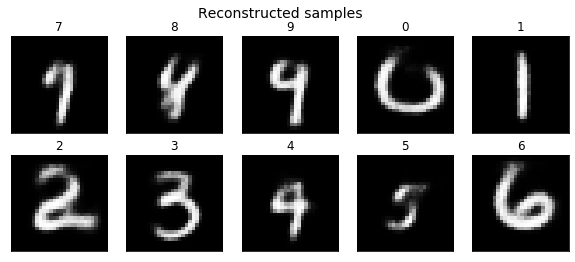

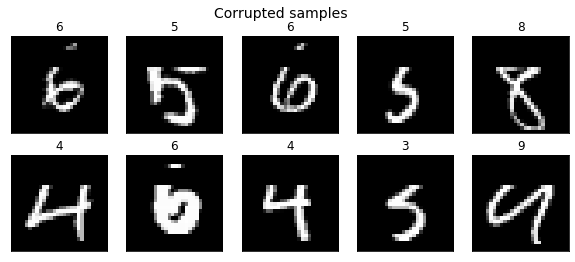

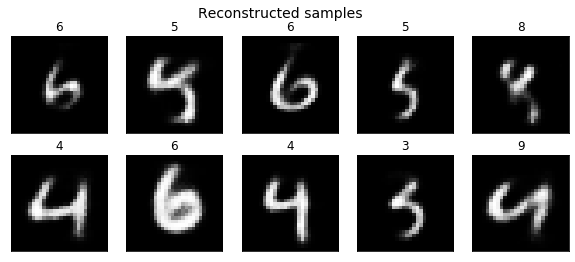

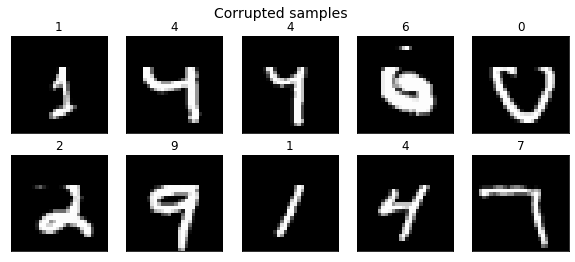

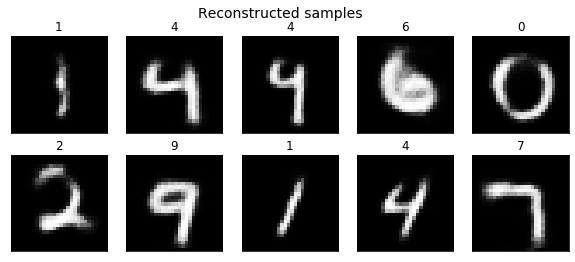

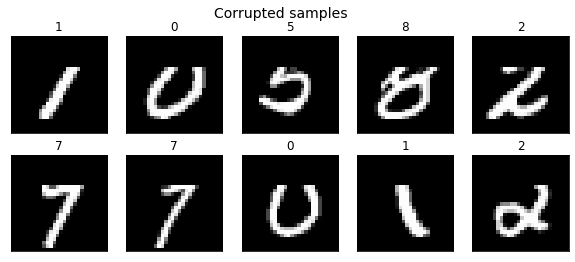

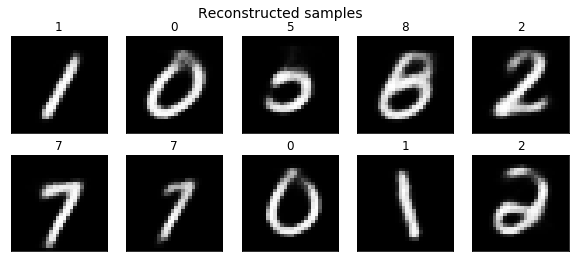

In [9]:
dbn.corrupt_and_recreate(Xtest.clone(), Ytest.clone())

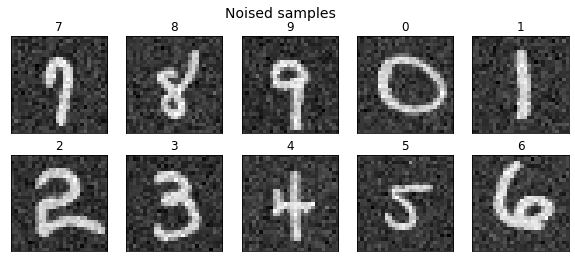

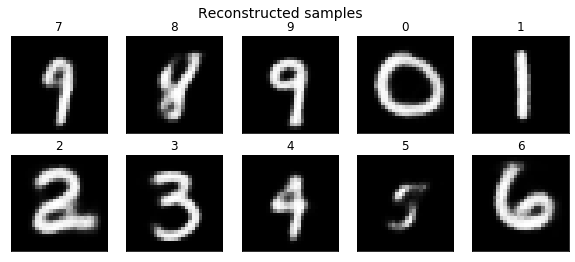

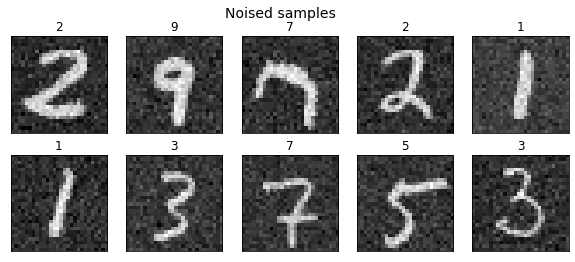

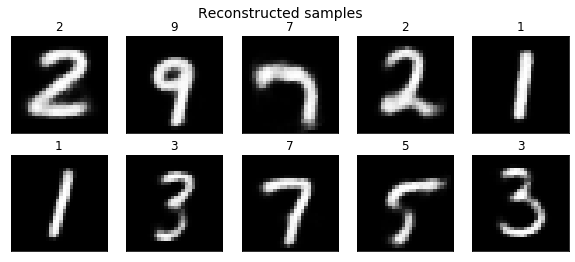

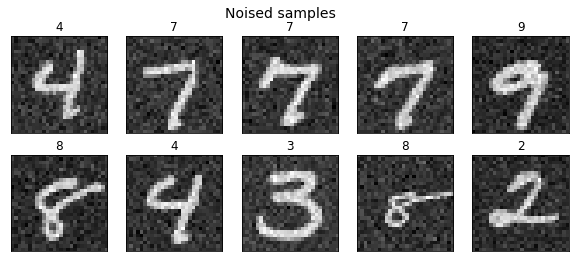

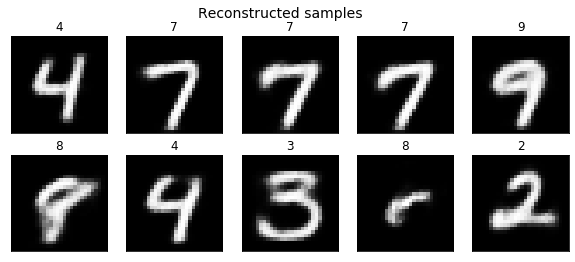

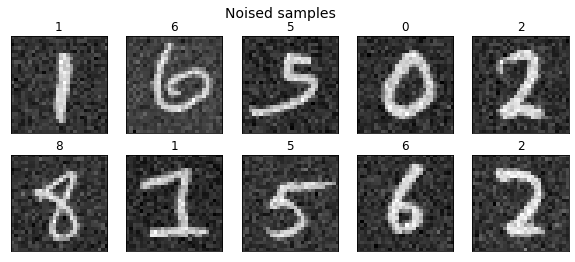

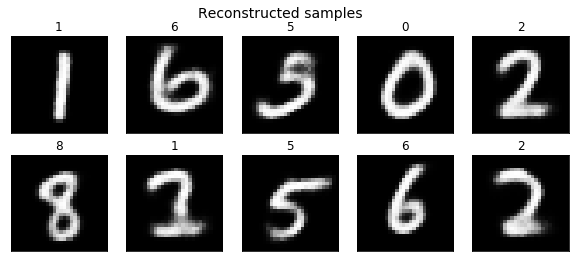

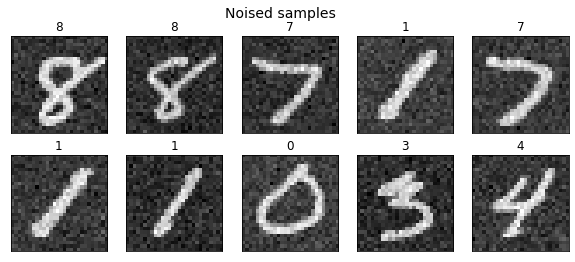

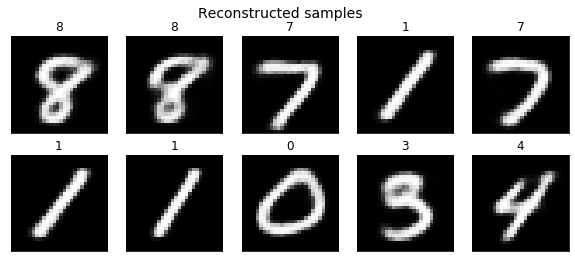

In [10]:
dbn.noise_and_denoise(Xtest.clone(), Ytest.clone(), title = 'Noised samples')